In [1]:
from sklearn.base import BaseEstimator, TransformerMixin

def logscale(x):
    return np.sign(x) * np.log(np.abs(x))


def log1pscale(x):
    return np.sign(x) * np.log1p(np.abs(x))


class Correlatum(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        transformations={
            "log_scale": logscale,
            "log_1p_scale": log1pscale,
            # "log": np.log,
            # "expm1": np.expm1,
            "sqrt": lambda x: np.sqrt(np.abs(x)),
            "square": np.square,
            "cube": lambda x: np.power(x, 3),
        },
    ):
        self.transformations = transformations

    def fit(self, X, y):

        # Fazer uma cópia do datafrmae
        X = X.copy()

        # Testar se a entrada é um dataframe
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Calcula todos os valores como porcentagens das médias nas colunas
        # X = (X) / np.array([X.mean().values])

        # Calcula a correlação com o target
        corr_base = (
            X_train.assign(y=y).corr()["y"].drop("y").abs().sort_values(ascending=False)
        )

        # Inicia uma variável para guardar as informações
        self.results = {}

        self.column_transformations = {}

        # Loop pelas colunas
        for col in X.columns:

            # Média da coluna
            # column_mean = X[col].mean()

            # Inicializando a coluna com o valor preprocessado
            result = X_train[[col]]

            # Assume que a correlação do preprocessamento é a maior
            max_corr = corr_base[col]
            self.results[col] = {col: {"max_corr": max_corr, "best_transf": "none"}}
            self.column_transformations[col] = lambda x: x

            # Calcula o número de infinitos
            n_inf = np.isinf(X[col]).sum()

            # Calcula o número de nans
            n_nan = np.isnan(X[col]).sum()

            # Para cada transformação
            for k in self.transformations:

                # Define a transformação
                transformation = self.transformations[k]

                # Executa a operação
                proposal_transf = transformation(result)

                # Reescalona em termos da média
                proposal_transf = proposal_transf / np.mean(
                    proposal_transf[
                        (~np.isinf(proposal_transf) & (~np.isnan(proposal_transf)))
                    ]
                )

                # Calcula o número de infinitos
                n_inf_transf = np.isinf(proposal_transf.values.flatten()).sum()

                # Calcula o número de nans
                # n_nan_transf = np.isnan(proposal_transf.values.flatten()).sum()

                # Calcula a correlação da transformação com o target
                corr_ = proposal_transf.assign(y=y).corr()["y"].abs()[col]

                # Calcula a razão dessa correlação com a máxima
                ratio = corr_ / max_corr

                # Checa se a transformação gerou alguma melhora
                if (ratio > 1) and (
                    n_inf_transf <= n_inf
                ):  # and (n_nan_transf <= n_nan):

                    max_corr = corr_

                    self.column_transformations[col] = transformation

                    self.results[col] = {col: {"max_corr": max_corr, "best_transf": k}}

        return self

    def transform(self, X, y=None):

        X_ = X.copy()

        for col in X_:
            X_[col] = self.column_transformations[col](X_[col])

        return X_  # .fillna(X_.mean())

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)


from sklearn.impute import SimpleImputer


class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.imputer = SimpleImputer().fit(X)
        return self

    def transform(self, X, y=None):
        columns = X.columns
        index = X.index
        return pd.DataFrame(self.imputer.transform(X), columns=columns, index=index)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

NameError: name 'np' is not defined

In [2]:
import sys
import pandas as pd
import numpy as np
from xtlearn.preprocessing import NumericBinner
from xtlearn.feature_selection import PvalueSelector
from sklearn.model_selection import train_test_split

df = pd.read_csv('/home/risknow/Datasets/heart.csv')
X = df.drop(columns="output")
y = df["output"]

# faking some nans
# X.loc[X['age'] < 40, 'age'] = np.nan

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42,
)

In [13]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples = 1000, n_features = 15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

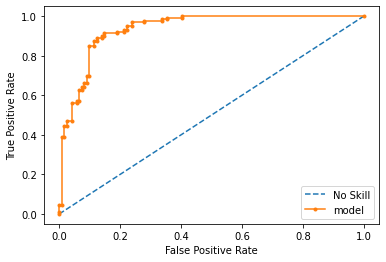

0.9358350409836065

In [17]:
from xtlearn.visualization import roc_auc_plot

roc_auc_plot(classifier, X_test, y_test)

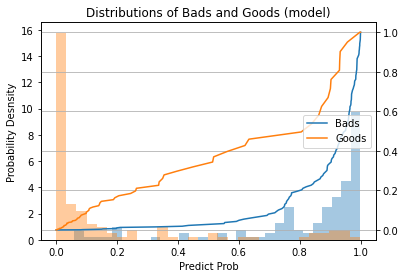

KstestResult(statistic=0.7676741803278688, pvalue=8.522446829616743e-39)

In [20]:
from xtlearn.visualization import ks_2sample_plot

ks_2sample_plot(classifier, X_test, y_test, bins=30)

In [2]:
selector = PvalueSelector()

selector.fit(X_train,y_train)

selector.transform(X_train)

,age,sex,cp,trtbps,chol,thalachh,exng,oldpeak,slp,caa,thall
144,76,0,2,140,197,116,0,1.1,1,0,2
215,43,0,0,132,341,136,1,3.0,1,0,3
230,47,1,2,108,243,152,0,0.0,2,0,2
66,51,1,2,100,222,143,1,1.2,1,0,2
288,57,1,0,110,335,143,1,3.0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...
170,56,1,2,130,256,142,1,0.6,1,1,1
59,57,0,0,128,303,159,0,0.0,2,1,2
37,54,1,2,150,232,165,0,1.6,2,0,3
116,41,1,2,130,214,168,0,2.0,1,0,2


In [4]:
# import warnings

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=DeprecationWarning)
#     import md5, sha
    
binner = NumericBinner().fit(X_train,y_train)

In [5]:
binner.bins['age']

,total,0,%0,1,%1,woe,iv,min,max,mean,std,total_iv
bin,,,,,,,,,,,,
1,31,9,0.092784,22,0.191304,-0.723597,0.071289,29,43,40.096774,3.112928,0.372866
2,37,12,0.123711,25,0.217391,-0.563748,0.052812,44,50,46.324324,2.055535,0.372866
3,41,16,0.164948,25,0.217391,-0.276066,0.014478,51,55,52.853659,1.492665,0.372866
4,30,19,0.195876,11,0.095652,0.716765,0.071837,56,58,57.166667,0.791478,0.372866
5,36,25,0.257732,11,0.095652,0.991202,0.160654,59,63,60.805556,1.450506,0.372866
6,37,16,0.164948,21,0.182609,-0.101713,0.001796,64,77,67.189189,3.389836,0.372866


In [6]:
X.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall'],
      dtype='object')

In [7]:
eval_information_value(
    binner, y_train, y_values=[0, 1], goods=0, treat_inf=True
)

NameError: name 'eval_information_value' is not defined

In [8]:
column = binner
target = y_train

In [227]:
def check_value(x, ref):
    return np.sum(np.where(x == ref, 1, 0))

data = pd.DataFrame({"feature": column, "target": target})

df = data.groupby("feature").agg(
    **{
        "total": ("target", "count"),
    }
)

# for val in y_values:

#     df = df.merge(
#         data.groupby("feature").agg(
#             **{
#                 str(val): ("target", lambda x: check_value(x, val)),
#             }
#         ),
#         left_index=True,
#         right_index=True,
#         how="left",
#     )

#     sum_val = df[str(val)].sum()
#     df["%" + str(val)] = df[str(val)] / sum_val

# def log_0(c_0, c_1):
#     if c_0 == 0:
#         return -np.inf
#     elif c_1 == 0:
#         return np.inf
#     elif (c_0 != 0) & (c_1 != 0):
#         return np.log(c_0 / c_1)

# if goods == 0:
#     df["woe"] = df.apply(lambda row: log_0(row["%0"], row["%1"]), axis=1)
#     df["iv"] = (df["%0"] - df["%1"]) * df["woe"]
# else:
#     df["woe"] = df.apply(lambda row: log_0(row["%0"], row["%1"]), axis=1)
#     df["iv"] = (df["%1"] - df["%0"]) * df["woe"]

# if treat_inf:
#     df = treat_iv_infinity(df)


In [231]:
data.groupby("feature").agg(
    **{
        "total": ("target", "count"),
    }
)

,total
feature,
1.0,99
2.0,103


In [170]:
bins = {}
iv_temp = 0
i = 4
column_name = "age"
X_copy = X_train.copy()
X_local = X_copy.copy()

X_temp = X_local.loc[X_local[column_name].notna()][[column_name]].copy()
n = len(X_temp)
n_quant = 1000 if n >= 1000 else n

binner = Pipeline(
    steps=(
        ("scaler", RobustScaler()),
        (
            "quantile",
            QuantileTransformer(output_distribution="uniform", n_quantiles=n_quant),
        ),
        (
            "binning",
            KBinsDiscretizer(n_bins=i, strategy="kmeans", encode="ordinal"),
        ),
    )
)

X_temp[column_name + "_transf"] = binner.fit_transform(X_temp).flatten() + 1
X_temp[column_name + "_transf"] = X_temp[column_name + "_transf"].astype(
    int, errors="ignore"
)
X_temp.loc[X_copy[column_name].isna(), column_name + "_transf"] = 0

summary = X_temp.groupby(column_name + "_transf").agg(
    col_min=(column_name, "min"),
    col_max=(column_name, "max"),
    col_mean=(column_name, "mean"),
    col_std=(column_name, "std"),
)


X_local.loc[X_local[column_name].notna(), column_name] = X_temp[column_name + "_transf"]

# X_local.loc[X_copy[column_name].isna(), column_name] = 0
# X_local[column_name] = X_local[column_name].astype(int, errors="ignore")

iv = eval_information_value(
    X_local[column_name], y, y_values=[0, 1], goods=0, treat_inf=True
)

iv = iv.merge(
    summary.reset_index(), how="left", right_on=column_name + "_transf", left_index=True
).set_index(column_name + "_transf")

X_local[column_name] = X_local[column_name].apply(
    lambda x: iv["woe"][x]
)

if (iv["iv"].sum() > iv_temp) & (
    np.isfinite(X_local[column_name].unique()).all()
):
    iv_temp = iv["iv"].sum()
    bin_temp = iv
    binner_temp = binner

In [83]:
binner.bins['age']

,total,0,%0,1,%1,woe,iv
feature,,,,,,,
1,31,9,0.092784,22,0.191304,-0.723597,0.071289
2,37,12,0.123711,25,0.217391,-0.563748,0.052812
3,41,16,0.164948,25,0.217391,-0.276066,0.014478
4,30,19,0.195876,11,0.095652,0.716765,0.071837
5,36,25,0.257732,11,0.095652,0.991202,0.160654
6,37,16,0.164948,21,0.182609,-0.101713,0.001796


In [16]:
eval_information_value(
    X_train['restecg'], y_train, y_values=[0, 1], goods=0, treat_inf=True
)

,total,0,%0,1,%1,woe,iv
feature,,,,,,,
0,98,51,0.525773,47,0.408696,0.251899,0.029492
1,110,43,0.443299,67,0.582609,-0.273271,0.038069
2,4,3,0.030928,1,0.008696,1.268833,0.028209
